# Microscopic Traffic Simulation

We develop a microscopic traffic model and simulation reflecting the traffic flow at the intersection of Albert-Einstein-Straße and Satower Straße/Südring in Rostock.

**Research Question:** With the model we aim to find a traffic light configuration that minimizes the longest_traffic_jam@output_variable of the entire intersection. 

**Components**: The model needs to consist of 4 components: 
* Traffic light model, 
* Car model, 
* Road model,
* Main simulation loop.

**Assumption:** Adjusting the traffic lights at the roads with the most traffic will have the highest impact:

In [1]:
k1_green_time=[55,75,1] # @parameter

k3_green_time=[55,75,1] # @parameter

## Traffic Light Model

In [2]:
import pygame
import sys
import random

def enum(**enums):
    return type('Enum', (), enums)


TrafficLightState = enum(RED=0, RED_YELLOW=1, GREEN=2, YELLOW=3)


class TrafficLight:
    traffic_lights = []

    def __init__(self, x, y, state, screen, circuit):
        self.x = x
        self.y = y

        self.state = state
        self.circuit = circuit

        self.screen = screen

        self.traffic_lights.append(self)

    def draw(self):
        pygame.draw.rect(self.screen, (0, 0, 0), (self.x, self.y, 40, 120))

        if self.state == TrafficLightState.GREEN:
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 20), 20)
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 60), 20)
            pygame.draw.circle(self.screen, (0, 255, 0), (self.x + 20, self.y + 100), 20)

        if self.state == TrafficLightState.YELLOW:
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 20), 20)
            pygame.draw.circle(self.screen, (255, 255, 0), (self.x + 20, self.y + 60), 20)
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 100), 20)

        if self.state == TrafficLightState.RED_YELLOW:
            pygame.draw.circle(self.screen, (255, 0, 0), (self.x + 20, self.y + 20), 20)
            pygame.draw.circle(self.screen, (255, 255, 0), (self.x + 20, self.y + 60), 20)
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 100), 20)

        if self.state == TrafficLightState.RED:
            pygame.draw.circle(self.screen, (255, 0, 0), (self.x + 20, self.y + 20), 20)
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 60), 20)
            pygame.draw.circle(self.screen, (119, 119, 119), (self.x + 20, self.y + 100), 20)


pygame 2.1.2 (SDL 2.0.18, Python 3.9.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Car Model

In [3]:
def enum(**enums):
    return type('Enum', (), enums)


Origin = enum(NORTH=0, EAST=1, SOUTH=2, WEST=3)
DrivingIntention = enum(LEFT=-1, FORWARD=0, RIGHT=1)


class Car:
    cars_up = []
    cars_up_left = []
    cars_up_right = []
    cars_down_left = []
    cars_down_right = []
    cars_right = []
    cars_left = []
    cars_left_up = []

    def __init__(self, x, y, origin, driving_intention, starting_time, ending_time=0, angle=0, velocity=4,
                 img="car.png", min_distance=130):
        self.x = x
        self.y = y

        self.angle = angle
        self.starting_time = starting_time
        self.ending_time = ending_time
        self.rotation_point_x = 0
        self.rotation_point_y = 0

        self.driving_intention = driving_intention
        self.origin = origin

        self.velocity = velocity
        self.velocity_old = 0
        self.max_velocity = 6

        self.distance = 10000
        self.min_distance = min_distance

        self.distance_to_traffic_light = 10000
        self.traffic_light = None
        self.is_waiting = False

        self.waiting_time = 0

        self.car_list = []

        if self.driving_intention == DrivingIntention.FORWARD:
            if self.origin == Origin.EAST:
                self.initial_car_list(Car.cars_left)

            if self.origin == Origin.SOUTH:
                self.initial_car_list(Car.cars_up)

            if self.origin == Origin.WEST:
                self.initial_car_list(Car.cars_right)

            if self.origin == Origin.NORTH:

                if self.x == 473:
                    self.initial_car_list(Car.cars_down_right)

                if self.x == 573:
                    self.initial_car_list(Car.cars_down_left)

        if self.driving_intention == DrivingIntention.RIGHT:
            if self.origin == Origin.NORTH:
                self.initial_car_list(Car.cars_down_right)

            if self.origin == Origin.EAST:
                self.initial_car_list(Car.cars_left_up)

            if self.origin == Origin.SOUTH:
                self.initial_car_list(Car.cars_up_right)

            if self.origin == Origin.WEST:
                self.initial_car_list(Car.cars_right)

        if self.driving_intention == DrivingIntention.LEFT:
            if self.origin == Origin.NORTH:
                self.initial_car_list(Car.cars_down_left)

            if self.origin == Origin.EAST:
                self.initial_car_list(Car.cars_left)

            if self.origin == Origin.SOUTH:
                self.initial_car_list(Car.cars_up_left)

            if self.origin == Origin.WEST:
                self.initial_car_list(Car.cars_right)

        self.image = pygame.transform.scale(pygame.image.load(img),
                                            (90, 90)) if img == "car.png" else pygame.transform.scale(
            pygame.image.load(img), (180, 70))

    def initial_car_list(self, car_list):
        car_list.append(self)
        self.car_list = car_list

    def change_car_list(self, car_list):
        if self.car_list == car_list:
            return

        if self in car_list:
            return

        if not car_list:
            car_list.append(self)

        elif car_list == Car.cars_down_right:
            if self.y > car_list[0].y:
                car_list.insert(0, self)

            elif self.y <= car_list[len(car_list) - 1].y:
                car_list.append(self)

            else:
                for i in range(len(car_list)):
                    if car_list[i].y >= self.y > car_list[i + 1].y:
                        car_list.insert(i + 1, self)

        elif car_list == Car.cars_left:
            if self.x < car_list[0].x:
                car_list.insert(0, self)

            elif self.x >= car_list[len(car_list) - 1].x:
                car_list.append(self)

            else:
                for i in range(len(car_list)):
                    if car_list[i].x <= self.x < car_list[i + 1].x:
                        car_list.insert(i + 1, self)

        elif car_list == Car.cars_up:
            if self.y < car_list[0].y:
                car_list.insert(0, self)

            elif self.y >= car_list[len(car_list) - 1].y:
                car_list.append(self)

            else:
                for i in range(len(car_list)):
                    if car_list[i].y <= self.y < car_list[i + 1].y:
                        car_list.insert(i + 1, self)

        elif car_list == Car.cars_right:
            if self.x > car_list[0].x:
                car_list.insert(0, self)

            elif self.x <= car_list[len(car_list) - 1].x:
                car_list.append(self)

            else:
                for i in range(len(car_list)):
                    if car_list[i].x >= self.x > car_list[i + 1].x:
                        car_list.insert(i + 1, self)

        self.car_list.remove(self)
        self.car_list = car_list

    def calculate_distance(self):
        if self.car_list.index(self) == 0:
            return

        car = self.car_list[self.car_list.index(self) - 1]
        v = 0
        if self.min_distance == car.min_distance:
            v = 0
        elif self.min_distance == 130 and car.min_distance == 220:
            v = -90
        elif self.min_distance == 220 and car.min_distance == 130:
            v = 90

        if self.driving_intention == DrivingIntention.FORWARD:
            if self.origin == Origin.EAST:
                self.distance = self.x - car.x

            if self.origin == Origin.SOUTH:
                self.distance = self.y - (car.y + v)

            if self.origin == Origin.WEST:
                self.distance = car.x - self.x

            if self.origin == Origin.NORTH:
                self.distance = car.y - (self.y + v)

        if self.driving_intention == DrivingIntention.RIGHT:
            if self.origin == Origin.NORTH:
                alpha = 270
                beta = 180
                x = 268
                y = 212
                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = car.y - self.y

                elif self.angle == car.angle == beta:
                    """both after turn"""
                    self.distance = self.x - car.x

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += x - car.x
                    self.distance += y - self.y

                elif self.angle < alpha and car.angle > beta:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (self.angle - car.angle) / 360)

                elif self.angle == alpha and car.angle > beta:
                    """i am before the turn, car is turning"""
                    self.distance = (2 * np.pi * 200 * (alpha - car.angle) / 360)
                    self.distance += y - self.y

                elif self.angle > beta and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (self.angle - beta) / 360)
                    self.distance += x - car.x

            if self.origin == Origin.EAST:
                alpha = 180
                beta = 90
                x = 1173
                y = 112
                if self.angle == car.angle == alpha:
                    """both before the turn"""
                    self.distance = self.x - car.x

                elif self.angle == car.angle == beta:
                    """both after the turn"""
                    self.distance = self.y - car.y

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += y - car.y
                    self.distance += self.x - x

                elif self.angle < alpha and car.angle > beta:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (self.angle - car.angle) / 360)

                elif self.angle == alpha and car.angle > beta:
                    """i am before turn, car is turning"""
                    self.distance = (2 * np.pi * 200 * (alpha - car.angle) / 360)
                    self.distance += self.x - x

                elif self.angle > beta and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (self.angle - beta) / 360)
                    self.distance += y - car.y

            if self.origin == Origin.SOUTH:
                alpha = 90
                beta = 0
                x = 1173
                y = 717
                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = self.y - car.y

                elif self.angle == car.angle == beta:
                    """both after turn"""
                    self.distance = car.x - self.x

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += car.x - x
                    self.distance += self.y - y

                elif self.angle < alpha and car.angle > beta:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (self.angle - car.angle) / 360)

                elif self.angle == alpha and car.angle > beta:
                    """i am before turn, car turning"""
                    self.distance = (2 * np.pi * 200 * (alpha - car.angle) / 360)
                    self.distance += self.y - y

                elif self.angle > beta and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * self.angle / 360)
                    self.distance += car.x - x

            if self.origin == Origin.WEST:
                alpha = 0
                beta = 270
                x = 268
                y = 717
                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = car.x - self.x

                elif self.angle == car.angle == beta:
                    """both after turn"""
                    self.distance = car.y - self.y

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += car.y - y
                    self.distance += x - self.x

                elif self.angle < 0 and car.angle < 0:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (self.angle % 360 - car.angle % 360) / 360)

                elif self.angle == alpha and car.angle < 0:
                    """i am before turn, car turning"""
                    self.distance = (2 * np.pi * 200 * (360 - car.angle % 360) / 360)
                    self.distance += x - self.x

                elif self.angle < 0 and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (self.angle % 360 - 270) / 360)
                    self.distance += car.y - y

        if self.driving_intention == DrivingIntention.LEFT:
            if self.origin == Origin.NORTH:
                alpha = 270
                beta = 0
                x = 768
                y = 317

                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = car.y - self.y

                elif self.angle == car.angle == 0:
                    """beide after turn"""
                    self.distance = car.x - self.x

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += car.x - x
                    self.distance += y - self.y

                elif self.angle > alpha and car.angle > alpha:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - self.angle) / 360)

                elif self.angle == alpha and car.angle > alpha:
                    """i am before turn, car turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - alpha) / 360)
                    self.distance += y - self.y

                elif self.angle > alpha and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (360 - self.angle) / 360)
                    self.distance += car.x - x

            if self.origin == Origin.EAST:
                alpha = 180
                beta = 270
                x = 673
                y = 612
                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = self.x - car.x

                elif self.angle == car.angle == beta:
                    """both after turn"""
                    self.distance = car.y - self.y

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += car.y - y
                    self.distance += self.x - x

                elif self.angle > alpha and car.angle < beta:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - self.angle) / 360)

                elif self.angle == alpha and car.angle < beta:
                    """i am before turn, car turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - alpha) / 360)
                    self.distance += self.x - x

                elif self.angle < beta and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (beta - self.angle) / 360)
                    self.distance += car.y - y

            if self.origin == Origin.SOUTH:
                alpha = 90
                beta = 180
                x = 668
                y = 612

                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = self.y - car.y

                elif self.angle == car.angle == beta:
                    """both after turn"""
                    self.distance = self.x - car.x

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += x - car.x
                    self.distance += self.y - y

                elif self.angle > alpha and car.angle < beta:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - self.angle) / 360)

                elif self.angle == alpha and car.angle < beta:
                    """i am before turn, car turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - alpha) / 360)
                    self.distance += self.y - y

                elif self.angle > beta and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (beta - self.angle) / 360)
                    self.distance += x - car.x

            if self.origin == Origin.WEST:
                alpha = 0
                beta = 90
                x = 773
                y = 312
                if self.angle == car.angle == alpha:
                    """both before turn"""
                    self.distance = car.x - self.x

                elif self.angle == car.angle == beta:
                    """both after turn"""
                    self.distance = self.y - car.y

                elif self.angle == alpha and car.angle == beta:
                    """both on straight line"""
                    self.distance = 2 * np.pi * 200 / 4
                    self.distance += y - car.y
                    self.distance += x - self.x

                elif self.angle > alpha and car.angle < beta:
                    """both turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - self.angle) / 360)

                elif self.angle == alpha and car.angle < beta:
                    """i am before turn, car turning"""
                    self.distance = (2 * np.pi * 200 * (car.angle - alpha) / 360)
                    self.distance += x - self.x

                elif self.angle < beta and car.angle == beta:
                    """i am turning, car after turn"""
                    self.distance = (2 * np.pi * 200 * (beta - self.angle) / 360)
                    self.distance += y - car.y

    def forward(self):
        if self.angle == 0:
            self.x += self.velocity

        if self.angle == 90:
            self.y -= self.velocity

        if self.angle == 180:
            self.x -= self.velocity

        if self.angle == 270:
            self.y += self.velocity

    def left(self):
        if self.angle == 90:
            self.rotation_point_x = self.x - 200
            self.rotation_point_y = self.y

        if self.angle == 180:
            self.rotation_point_x = self.x
            self.rotation_point_y = self.y + 200

        if self.angle == 270:
            self.rotation_point_x = self.x + 200
            self.rotation_point_y = self.y

        if self.angle == 0:
            self.rotation_point_x = self.x
            self.rotation_point_y = self.y - 200

        self.angle += np.round(self.velocity / np.pi)
        self.x = self.rotation_point_x + np.round(200 * np.cos((self.angle + 270) * np.pi / 180))
        self.y = self.rotation_point_y + np.round(200 * np.sin((self.angle + 90) * np.pi / 180))

    def right(self):
        if self.angle == 90:
            self.rotation_point_x = self.x + 200
            self.rotation_point_y = self.y

        if self.angle == 180:
            self.rotation_point_x = self.x
            self.rotation_point_y = self.y - 200

        if self.angle == 270:
            self.rotation_point_x = self.x - 200
            self.rotation_point_y = self.y

        if self.angle == 0:
            self.rotation_point_x = self.x
            self.rotation_point_y = self.y + 200

        self.angle -= np.round(self.velocity / np.pi)
        self.x = self.rotation_point_x + np.round(200 * np.cos((self.angle + 90) * np.pi / 180))
        self.y = self.rotation_point_y + np.round(200 * np.sin((self.angle + 270) * np.pi / 180))

    def is_outside(self):
        if self.x <= -100:
            if self.origin != Origin.WEST:
                return True

        if self.x >= 1536:
            if self.origin != Origin.EAST:
                return True

        if self.y <= -100:
            if self.origin != Origin.NORTH:
                return True

        if self.y >= 1024:
            if self.origin != Origin.SOUTH:
                return True

        return False

    def calculate_distance_to_traffic_light(self):
        if self.origin == Origin.NORTH:
            if self.min_distance == 220:
                self.distance_to_traffic_light = (132 - self.y) - 180
            else:
                self.distance_to_traffic_light = (132 - self.y) - 90

        if self.origin == Origin.EAST:
            self.distance_to_traffic_light = self.x - 1348

        if self.origin == Origin.SOUTH:
            self.distance_to_traffic_light = self.y - 792

        if self.origin == Origin.WEST:
            self.distance_to_traffic_light = (188 - self.x) - 90

    def drive(self):
        self.calculate_distance()
        if self.distance < 100:
            if self.origin == Origin.EAST:
                self.x = self.car_list[self.car_list.index(self) - 1].x + 220
            if self.origin == Origin.SOUTH:
                self.y = self.car_list[self.car_list.index(self) - 1].y + 220

            if self.origin == Origin.WEST:
                self.x = self.car_list[self.car_list.index(self) - 1].x - 220
            if self.origin == Origin.NORTH:
                self.y = self.car_list[self.car_list.index(self) - 1].y - 220
            self.distance = 220

        self.calculate_traffic_light()

        if self.traffic_light:
            self.calculate_distance_to_traffic_light()
            if self.traffic_light.state == TrafficLightState.RED:
                if 0 < self.distance_to_traffic_light < self.distance:
                    """calculate acceleration w.r.t. traffic light"""
                    self.calculate_acceleration(True)
                else:
                    """w.r.t. predecessor"""
                    self.calculate_acceleration(False)
            else:
                """w.r.t. predecessor"""
                self.calculate_acceleration(False)
        else:
            """w.r.t. predecessor"""
            self.calculate_acceleration(False)

        if self.driving_intention == DrivingIntention.FORWARD:
            if self.origin == Origin.NORTH:
                if 212 < self.y < 222:
                    self.distance_to_cross_traffic()
            if self.origin == Origin.EAST:
                if 1163 < self.x < 1173:
                    self.distance_to_cross_traffic()
            if self.origin == Origin.SOUTH:
                if 707 < self.y < 717:
                    self.distance_to_cross_traffic()
            if self.origin == Origin.WEST:
                if 273 < self.x < 283:
                    self.distance_to_cross_traffic()

            self.forward()

        elif self.driving_intention == DrivingIntention.LEFT:
            if self.origin == Origin.NORTH:
                if 212 < self.y < 222:
                    self.distance_to_cross_traffic()
                if self.y < 317:
                    self.forward()
                elif self.x >= 768:
                    self.change_car_list(Car.cars_right)
                    if self.x < 788:
                        self.distance_to_cross_traffic()
                    if not self.is_waiting:
                        self.forward()
                else:
                    self.distance_to_cross_traffic()
                    self.left()
                    if self.x > 768:
                        self.x = 768
                        self.y = 517
                        self.angle = 0
            elif self.origin == Origin.EAST:
                if 1163 < self.x < 1173:
                    self.distance_to_cross_traffic()
                if self.x > 673:
                    self.forward()
                elif self.y >= 612:
                    self.change_car_list(Car.cars_down_right)
                    self.distance_to_cross_traffic()
                    self.forward()
                else:
                    self.distance_to_cross_traffic()
                    self.left()
                    if self.y > 612:
                        self.x = 473
                        self.y = 612
                        self.angle = 270
            elif self.origin == Origin.SOUTH:
                if 707 < self.y < 717:
                    self.distance_to_cross_traffic()
                if self.y > 612:
                    self.forward()
                elif self.x <= 668:
                    self.change_car_list(Car.cars_left)
                    self.distance_to_cross_traffic()
                    self.forward()
                else:
                    self.distance_to_cross_traffic()
                    self.left()
                    if self.x < 668:
                        self.x = 668
                        self.y = 412
                        self.angle = 180
            elif self.origin == Origin.WEST:
                if 273 < self.x < 283:
                    self.distance_to_cross_traffic()
                if self.x < 773:
                    self.forward()
                elif self.y <= 312:
                    self.change_car_list(Car.cars_up)
                    self.distance_to_cross_traffic()
                    self.forward()
                else:
                    self.distance_to_cross_traffic()
                    self.left()
                    if self.y < 312:
                        self.x = 973
                        self.y = 312
                        self.angle = 90
        elif self.driving_intention == DrivingIntention.RIGHT:
            if self.origin == Origin.NORTH:
                if self.y < 212:
                    self.forward()
                elif self.x <= 268:
                    self.change_car_list(Car.cars_left)
                    self.forward()
                else:
                    if not self.is_waiting:
                        self.right()
                    if 50 < self.angle % 90 < 60:
                        self.distance_to_cross_traffic()
                    if self.x < 268:
                        self.x = 268
                        self.y = 412
                        self.angle = 180
            if self.origin == Origin.EAST:
                if self.x > 1173:
                    self.forward()
                elif self.y <= 112:
                    self.change_car_list(Car.cars_up)
                    self.forward()
                else:
                    if not self.is_waiting:
                        self.right()
                    if 40 < self.angle % 90 < 50:
                        self.distance_to_cross_traffic()
                    if self.y < 112:
                        self.x = 973
                        self.y = 112
                        self.angle = 90
            if self.origin == Origin.SOUTH:
                if self.y > 717:
                    self.forward()
                elif self.x >= 1268:
                    self.change_car_list(Car.cars_right)
                    self.forward()
                else:
                    if not self.is_waiting:
                        self.right()
                    if 40 < self.angle % 90 < 50:
                        self.distance_to_cross_traffic()
                    if self.x > 1268:
                        self.x = 1268
                        self.y = 517
                        self.angle = 0
            if self.origin == Origin.WEST:
                if self.x < 273:
                    self.forward()
                elif self.y >= 712:
                    self.change_car_list(Car.cars_down_right)
                    self.forward()
                else:
                    if not self.is_waiting:
                        self.right()
                    if 60 < self.angle % 90 < 70:
                        self.distance_to_cross_traffic()
                    if self.y > 712:
                        self.x = 473
                        self.y = 712
                        self.angle = 270

        if self.velocity < -0.5:
            self.car_list.remove(self)

    def calculate_acceleration(self, tl):
        if tl:
            distance = self.distance_to_traffic_light
            velocity = 0
            minimum_distance = 20
        else:
            distance = self.distance
            if self.car_list.index(self) == 0:
                velocity = self.max_velocity
                minimum_distance = 20
            else:
                velocity = self.car_list[self.car_list.index(self) - 1].velocity
                minimum_distance = self.car_list[self.car_list.index(self) - 1].min_distance

        if self.min_distance == 220:
            max_acceleration = 2
        else:
            max_acceleration = 4

        if self.min_distance == 220:
            delta = 2
        else:
            delta = 8

        coefficient_with_delta = (self.velocity / self.max_velocity) ** delta
        s_star = minimum_distance + (self.velocity * (distance / self.max_velocity)) + (
                (self.velocity * (self.velocity - velocity)) / (2 * np.sqrt(max_acceleration * 1.5)))
        acceleration = max_acceleration * (1 - coefficient_with_delta - (s_star / distance) ** 2)

        self.velocity_old = self.velocity
        self.velocity += acceleration

    def calculate_traffic_light(self):
        if self.origin == Origin.NORTH:
            if self.min_distance == 220:
                if self.y + 180 <= 212:
                    self.traffic_light = TrafficLight.traffic_lights[0]
                    return
            else:
                if self.y + 90 <= 212:
                    self.traffic_light = TrafficLight.traffic_lights[0]
                    return

        if self.origin == Origin.EAST:
            if self.x > 1268:
                self.traffic_light = TrafficLight.traffic_lights[1]
                return

        if self.origin == Origin.SOUTH:
            if self.y > 712:
                if self.x > 873:
                    self.traffic_light = TrafficLight.traffic_lights[2]
                    return
                else:
                    self.traffic_light = TrafficLight.traffic_lights[3]
                    return

        if self.origin == Origin.WEST:
            if self.x + 90 < 268 - 20:
                self.traffic_light = TrafficLight.traffic_lights[4]
                return

        self.traffic_light = None

    def distance_to_cross_traffic(self):
        min_dist = np.inf
        car_list = []
        if self.driving_intention == DrivingIntention.RIGHT:
            if self.origin == Origin.NORTH:
                car_list = Car.cars_left
            if self.origin == Origin.EAST:
                car_list = Car.cars_up
            if self.origin == Origin.SOUTH:
                car_list = Car.cars_right
            if self.origin == Origin.WEST:
                car_list = Car.cars_down_right

        if self.driving_intention == DrivingIntention.LEFT:
            if self.origin == Origin.NORTH:
                car_list = Car.cars_right + Car.cars_up + Car.cars_left
            if self.origin == Origin.EAST:
                car_list = Car.cars_down_right + Car.cars_down_left + Car.cars_up + Car.cars_right
            if self.origin == Origin.SOUTH:
                car_list = Car.cars_right + Car.cars_down_left + Car.cars_down_right + Car.cars_left
            if self.origin == Origin.WEST:
                car_list = Car.cars_left + Car.cars_up

        if self.driving_intention == DrivingIntention.FORWARD:
            if self.origin == Origin.NORTH:
                car_list = Car.cars_right
            if self.origin == Origin.EAST:
                car_list = Car.cars_down_right + Car.cars_down_left
            if self.origin == Origin.SOUTH:
                car_list = Car.cars_left
            if self.origin == Origin.WEST:
                car_list = Car.cars_up

        for car in car_list:
            if car == self:
                continue
            dist = np.sqrt((car.x - self.x) ** 2 + (car.y - self.y) ** 2)
            if dist < min_dist:
                min_dist = dist
        if min_dist < 300:
            self.is_waiting = True
            self.velocity = 0
        else:
            self.is_waiting = False


## Road Model

Below the different road sections are defined.

In [4]:
def draw_road(screen):
    pygame.draw.rect(screen, (119, 119, 119), (468, 0, 200, 1024))
    pygame.draw.rect(screen, (119, 119, 119), (868, 612, 300, 1024))
    pygame.draw.rect(screen, (119, 119, 119), (968, 0, 100, 692))

    pygame.draw.rect(screen, (119, 119, 119), (0, 412, 468, 300))
    pygame.draw.rect(screen, (119, 119, 119), (468, 312, 1068, 300))

    pygame.draw.rect(screen, (119, 119, 119), (268, 212, 200, 200))
    pygame.draw.circle(screen, (51, 102, 0), (268, 212), 200)

    pygame.draw.rect(screen, (119, 119, 119), (1068, 112, 200, 200))
    pygame.draw.rect(screen, (255, 255, 255), (1358, 312, 10, 200))
    pygame.draw.circle(screen, (51, 102, 0), (1268, 112), 200)

    pygame.draw.rect(screen, (119, 119, 119), (1168, 612, 200, 200))
    pygame.draw.rect(screen, (255, 255, 255), (868, 792, 400, 10))
    pygame.draw.circle(screen, (51, 102, 0), (1368, 812), 200)

    pygame.draw.rect(screen, (119, 119, 119), (268, 712, 200, 200))
    pygame.draw.circle(screen, (51, 102, 0), (268, 912), 200)

    pygame.draw.polygon(screen, (255, 255, 255), ((888, 842), (908, 862), (908, 822)))
    pygame.draw.rect(screen, (255, 255, 255), (908, 832, 10, 20))
    pygame.draw.rect(screen, (255, 255, 255), (918, 832, 20, 100))

    pygame.draw.polygon(screen, (255, 255, 255), ((1018, 822), (998, 842), (1038, 842)))
    pygame.draw.rect(screen, (255, 255, 255), (1008, 832, 20, 100))

    pygame.draw.polygon(screen, (255, 255, 255), ((1148, 842), (1128, 862), (1128, 822)))
    pygame.draw.rect(screen, (255, 255, 255), (1118, 832, 10, 20))
    pygame.draw.rect(screen, (255, 255, 255), (1098, 832, 20, 100))

    pygame.draw.rect(screen, (255, 255, 255), (963, 792, 10, 140))
    pygame.draw.rect(screen, (255, 255, 255), (1063, 792, 10, 140))

    pygame.draw.polygon(screen, (255, 255, 255), ((1408, 332), (1388, 352), (1428, 352)))
    pygame.draw.rect(screen, (255, 255, 255), (1398, 352, 20, 10))
    pygame.draw.rect(screen, (255, 255, 255), (1398, 362, 100, 20))

    pygame.draw.polygon(screen, (255, 255, 255), ((1388, 442), (1408, 462), (1408, 422)))
    pygame.draw.rect(screen, (255, 255, 255), (1408, 432, 90, 20))
    pygame.draw.rect(screen, (255, 255, 255), (1418, 452, 20, 20))
    pygame.draw.polygon(screen, (255, 255, 255), ((1448, 472), (1408, 472), (1428, 492)))

    pygame.draw.rect(screen, (255, 255, 255), (468, 112, 200, 10))
    pygame.draw.polygon(screen, (255, 255, 255), ((528, 82), (508, 62), (548, 62)))
    pygame.draw.rect(screen, (255, 255, 255), (518, -38, 20, 100))
    pygame.draw.rect(screen, (255, 255, 255), (498, 32, 20, 20))
    pygame.draw.polygon(screen, (255, 255, 255), ((498, 22), (498, 62), (478, 42)))

    pygame.draw.polygon(screen, (255, 255, 255), ((608, 82), (588, 62), (628, 62)))
    pygame.draw.rect(screen, (255, 255, 255), (598, -38, 20, 100))
    pygame.draw.rect(screen, (255, 255, 255), (618, 32, 20, 20))
    pygame.draw.polygon(screen, (255, 255, 255), ((638, 22), (638, 62), (658, 42)))

    pygame.draw.rect(screen, (255, 255, 255), (563, -38, 10, 150))

    pygame.draw.rect(screen, (255, 255, 255), (178, 512, 10, 200))

    pygame.draw.rect(screen, (255, 255, 255), (-22, 512, 200, 10))
    pygame.draw.rect(screen, (255, 255, 255), (-22, 612, 200, 10))
    pygame.draw.rect(screen, (255, 255, 255), (1358, 402, 140, 10))
    pygame.draw.rect(screen, (255, 255, 255), (1358, 512, 200, 10))


## Main Simulation Loop

Below, we define the run_simulation function as well as some auxiliary functions.

In [5]:
clkw = 0


def rotate(car, angle):
    surface = car.image
    rotated_surface = pygame.transform.rotozoom(surface, angle, 1)
    return rotated_surface


def amount_of_cars(rate):
    rand = random.uniform(0, 1)
    sum = i = 0
    while True:
        s = (np.exp(-rate / 1830) * (rate / 1830) ** i) / np.math.factorial(i)
        sum += s
        if rand < sum:
            break
        i += 1

    return i


def calculate_destination(cars, forward, right):
    rand = random.uniform(0, cars)
    if rand <= right:
        return DrivingIntention.RIGHT
    if rand <= right + forward:
        return DrivingIntention.FORWARD
    else:
        return DrivingIntention.LEFT


def draw_amount_of_cars(surface, font):
    white = (255, 255, 255)
    grey = (119, 119, 119)

    text = font.render(str(len(Car.cars_up)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (973 + 50, 1000)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_up_left)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (873 + 50, 1000)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_up_right)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (1073 + 50, 1000)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_down_left)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (573 + 50, 24)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_down_right)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (473 + 50, 24)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_right)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (24, 517 + 50)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_left)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (1512, 417 + 50)
    surface.blit(text, textRect)

    text = font.render(str(len(Car.cars_left_up)), True, white, grey)
    textRect = text.get_rect()
    textRect.center = (1512, 317 + 50)
    surface.blit(text, textRect)


def calculate_vehicle_type(kfz, lkw):
    global clkw
    rand = random.uniform(0, kfz)
    if rand < lkw:
        clkw += 1
        return 220, "lkw.png"
    else:
        return 130, "car.png"


# One simulation run, default values for lengths of the green phases
def replication(param_dictionary,
                outputs=['longest_traffic_jam', 'average_travelling', 'average_longest_travelling']):
    k1_green_time = 61
    k2_green_time = 115
    k3_green_time = 78
    k7_green_time = 11
    north_to_east = 86
    north_to_south = 862
    north_to_west = 5
    east_to_north = 63
    east_to_south = 26
    east_to_west = 1
    south_to_north = 680
    south_to_east = 55
    south_to_west = 3
    west_to_north = 12
    west_to_east = 5
    west_to_south = 12
    if 'k1_green_time' in param_dictionary:
        k1_green_time = param_dictionary.get('k1_green_time')
    if 'k2_green_time' in param_dictionary:
        k2_green_time = param_dictionary.get('k2_green_time')
    if 'k3_green_time' in param_dictionary:
        k3_green_time = param_dictionary.get('k3_green_time')
    if 'k7_green_time' in param_dictionary:
        k7_green_time = param_dictionary.get('k7_green_time')
    if 'north_to_east' in param_dictionary:
        north_to_east = param_dictionary.get('north_to_east')
    if 'north_to_south' in param_dictionary:
        north_to_south = param_dictionary.get('north_to_south')
    if 'north_to_west' in param_dictionary:
        north_to_west = param_dictionary.get('north_to_west')
    if 'east_to_north' in param_dictionary:
        east_to_north = param_dictionary.get('east_to_north')
    if 'east_to_south' in param_dictionary:
        east_to_south = param_dictionary.get('east_to_south')
    if 'east_to_west' in param_dictionary:
        east_to_west = param_dictionary.get('east_to_west')
    if 'south_to_north' in param_dictionary:
        south_to_north = param_dictionary.get('south_to_north')
    if 'south_to_east' in param_dictionary:
        south_to_east = param_dictionary.get('south_to_east')
    if 'south_to_west' in param_dictionary:
        south_to_west = param_dictionary.get('south_to_west')
    if 'west_to_north' in param_dictionary:
        west_to_north = param_dictionary.get('west_to_north')
    if 'west_to_east' in param_dictionary:
        west_to_east = param_dictionary.get('west_to_east')
    if 'west_to_south' in param_dictionary:
        west_to_south = param_dictionary.get('west_to_south')

    visualize = False

    if visualize:
        # initialize visualization
        pygame.init()
        size = (1536, 1024)
        screen = pygame.display.set_mode(size)
        surface = pygame.Surface(size)

        pygame.display.set_caption("Traffic Simulation")
        programIcon = pygame.image.load("icon.png")
        pygame.display.set_icon(programIcon)

        clock = pygame.time.Clock()

        font = pygame.font.Font('freesansbold.ttf', 32)
        # initialize simulation time for visualization
        fac = 1
    else:
        # initialize time if no visualization is used, speed up by factor 4
        surface = None
        fac = 4

    # Traffic light data from Rostock

    """K1"""
    # TrafficLight(373, 152, TrafficLightState.RED, surface, circuit=[39, 40, 101, 104])
    """K2"""
    # TrafficLight(1240, 152, TrafficLightState.GREEN, surface, circuit=[11, 14, 117, 118])
    """K3"""
    # TrafficLight(1223, 752, TrafficLightState.RED, surface, circuit=[19, 20, 99, 102])
    """K7"""
    # TrafficLight(773, 752, TrafficLightState.RED, surface, circuit=[18, 19, 30, 33])
    """K4"""
    # TrafficLight(273, 752, TrafficLightState.GREEN, surface, circuit=[11, 14, 117, 118])
    """K1"""
    # TrafficLight(723, 152, TrafficLightState.RED, surface, circuit=[39, 40, 101, 104])
    """K4"""
    # TrafficLight(273, 252, TrafficLightState.GREEN, surface, circuit=[11, 14, 117, 118])

    TrafficLight.traffic_lights = []
    """K1 up"""
    TrafficLight(373, 152, TrafficLightState.RED, surface,
                 circuit=[39, 40, (40 + k1_green_time) % 120, (43 + k1_green_time) % 120])
    """K2 right"""
    TrafficLight(1240, 152, TrafficLightState.GREEN, surface,
                 circuit=[(k2_green_time + 118) % 120, (k2_green_time + 121) % 120, 118 - 1, 118])
    """K3 südring"""
    TrafficLight(1223, 752, TrafficLightState.RED, surface,
                 circuit=[19, 20, (20 + k3_green_time) % 120, (23 + k3_green_time) % 120])
    """K7 turn left from above"""
    TrafficLight(773, 752, TrafficLightState.RED, surface,
                 circuit=[18, 19, (19 + k7_green_time) % 120, (22 + k7_green_time) % 120])
    """K4 gardens"""
    TrafficLight(273, 752, TrafficLightState.GREEN, surface,
                 circuit=[(k2_green_time + 118) % 120, (k2_green_time + 121) % 120, 117, 118])
    """K1"""
    TrafficLight(723, 152, TrafficLightState.RED, surface,
                 circuit=[39, 40, (40 + k1_green_time) % 120, (43 + k1_green_time) % 120])
    """K4"""
    TrafficLight(273, 252, TrafficLightState.GREEN, surface,
                 circuit=[(k2_green_time + 118) % 120, (k2_green_time + 121) % 120, 117, 118])

    # arguments for spawning the cars
    args = [(north_to_west + north_to_east + north_to_south, 473, -100, 270, north_to_east, north_to_south,
             north_to_west, Origin.NORTH), (
                east_to_west + east_to_north + east_to_south, 1636, 317, 180, east_to_south, east_to_west,
                east_to_north,
                Origin.EAST),
            (
                south_to_west + south_to_north + south_to_east, 973, 1124, 90, south_to_west, south_to_north,
                south_to_east,
                Origin.SOUTH), (
                west_to_north + west_to_east + west_to_south, -100, 517, 0, west_to_north, west_to_east, west_to_south,
                Origin.WEST)]
    random.seed()

    s = 1
    counter = 0
    w = t = ct = v = cv = c = 0
    waiting_times = []
    travel_times = []
    longest_traffic_jam = 0
    longest_traffic_jam_location = " "
    clkw = 0
    north_right = north_forward = north_left = east_right = east_forward = east_left = south_right = south_forward = \
        south_left = west_right = west_forward = west_left = 0

    while True:
        if visualize:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    sys.exit()
            # grey background
            surface.fill((51, 102, 0))
            # draw street
            draw_road(surface)

        if s % (60 * fac) == 0:
            for arg in args:
                for i in range(amount_of_cars(arg[0])):
                    driving_intention = calculate_destination(arg[0], arg[5], arg[6])

                    if arg[0] == args[2][0]:
                        if driving_intention == DrivingIntention.FORWARD:
                            min_distance, img = calculate_vehicle_type(20141, 411)
                        elif driving_intention == DrivingIntention.RIGHT:
                            min_distance, img = calculate_vehicle_type(10867, 740)
                        else:
                            min_distance, img = 130, "car.png"

                        Car(x=arg[1] + (driving_intention * 100), y=arg[2] + (i * 220), angle=arg[3],
                            starting_time=counter, velocity=3,
                            origin=arg[7],
                            driving_intention=driving_intention, min_distance=min_distance, img=img)

                        if driving_intention == DrivingIntention.RIGHT:
                            south_right += 1
                        if driving_intention == DrivingIntention.FORWARD:
                            south_forward += 1
                        if driving_intention == DrivingIntention.LEFT:
                            south_left += 1

                        c += 1

                    elif arg[0] == args[1][0]:
                        if driving_intention == DrivingIntention.LEFT:
                            Car(x=arg[1] + (i * 220), y=arg[2] + 100, angle=arg[3],
                                starting_time=counter, velocity=3,
                                origin=arg[7],
                                driving_intention=driving_intention)
                            east_left += 1
                            c += 1
                        if driving_intention == DrivingIntention.FORWARD:
                            Car(x=arg[1] + (i * 220), y=arg[2] + 100, angle=arg[3],
                                starting_time=counter, velocity=3,
                                origin=arg[7],
                                driving_intention=driving_intention)
                            east_forward += 1
                            c += 1
                        if driving_intention == DrivingIntention.RIGHT:
                            Car(x=arg[1] + (i * 220), y=arg[2], angle=arg[3], starting_time=counter,
                                velocity=3,
                                origin=arg[7],
                                driving_intention=driving_intention)
                            c += 1
                            east_right += 1

                    elif arg[0] == args[0][0]:
                        if driving_intention == DrivingIntention.RIGHT:
                            min_distance, img = calculate_vehicle_type(14066, 159)
                            Car(x=arg[1], y=arg[2] - (i * 220), angle=arg[3], starting_time=counter,
                                velocity=3,
                                origin=arg[7],
                                driving_intention=driving_intention, min_distance=min_distance, img=img)
                            c += 1
                            north_right += 1
                        if driving_intention == DrivingIntention.LEFT:
                            min_distance, img = calculate_vehicle_type(20326, 1224)
                            Car(x=arg[1] + 100, y=arg[2] - (i * 220), angle=arg[3],
                                starting_time=counter, velocity=3,
                                origin=arg[7],
                                driving_intention=driving_intention, min_distance=min_distance, img=img)
                            c += 1
                            north_left += 1
                        if driving_intention == DrivingIntention.FORWARD:
                            rand = random.uniform(0, 1)
                            indent = 0
                            if rand < 0.5:
                                indent = 100
                                min_distance, img = calculate_vehicle_type(20326, 1224)
                            else:
                                min_distance, img = calculate_vehicle_type(14066, 159)
                            Car(x=arg[1] + indent, y=arg[2] - (i * 220), angle=arg[3],
                                starting_time=counter,
                                velocity=3, origin=arg[7],
                                driving_intention=driving_intention, min_distance=min_distance, img=img)
                            north_forward += 1
                            c += 1

                    else:
                        Car(x=arg[1] - (i * 220), y=arg[2], angle=arg[3], starting_time=counter,
                            velocity=3,
                            origin=arg[7],
                            driving_intention=driving_intention)
                        if driving_intention == DrivingIntention.RIGHT:
                            west_right += 1
                        if driving_intention == DrivingIntention.FORWARD:
                            west_forward += 1
                        if driving_intention == DrivingIntention.LEFT:
                            west_left += 1
                        c += 1

            s = 0

        s += 1

        for traffic_light in TrafficLight.traffic_lights:
            for i in range(0, len(traffic_light.circuit)):
                if traffic_light.circuit[i] * 60 * fac == counter % (120 * 60 * fac):
                    traffic_light.state = (traffic_light.state + 1) % 4
            if visualize:
                traffic_light.draw()

        for car in Car.cars_up + Car.cars_up_left + Car.cars_up_right + Car.cars_down_left + Car.cars_down_right + Car.cars_right + Car.cars_left + Car.cars_left_up:
            car.drive()
            if car.velocity > 0.02:
                v += car.velocity
                cv += 1
            else:
                car.waiting_time += 1
            if visualize:
                surface.blit(rotate(car, car.angle), (car.x, car.y))

            if car.is_outside():
                waiting_times.append(car.waiting_time / (60 * fac))
                w += car.waiting_time / (60 * fac)

                car.ending_time = counter
                t += (car.ending_time - car.starting_time) / (60 * fac)
                travel_times.append((car.ending_time - car.starting_time) / (60 * fac))
                ct += 1

                car.car_list.remove(car)
                del car

        if visualize:
            # noinspection PyUnboundLocalVariable
            draw_amount_of_cars(surface, font)
            # noinspection PyUnboundLocalVariable
            screen.blit(surface, (0, 0))
            pygame.display.flip()
            # noinspection PyUnboundLocalVariable
            clock.tick(60)

        if c >= 183:
            v = v / cv
            t = t / ct

            w = w / c

            break

        counter += 1
        if len(Car.cars_up) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_up)
            longest_traffic_jam_location = "the lane from Südring to Satower Straße"
        if len(Car.cars_up_left) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_up_left)
            longest_traffic_jam_location = "the lane from Südring to Gartenkolonie"
        if len(Car.cars_up_right) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_up_right)
            longest_traffic_jam_location = "the lane from Südring to Albert-Einstein-Straße"
        if len(Car.cars_down_right) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_down_right)
            longest_traffic_jam_location = "the lane from Satower Straße to Albert-Einstein-Straße"
        if len(Car.cars_down_left) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_down_left)
            longest_traffic_jam_location = "the lane from Satower Straße to Gartenkolonie"
        if len(Car.cars_right) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_right)
            longest_traffic_jam_location = "the lane from Albert-Einstein-Straße to Gartenkolonie/Südring"
        if len(Car.cars_left) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_left)
            longest_traffic_jam_location = "the lane from Albert-Einstein-Straße to Satower Straße"
        if len(Car.cars_left_up) > longest_traffic_jam:
            longest_traffic_jam = len(Car.cars_left_up)
            longest_traffic_jam_location = "the lane from Gartenkolonie"
    output_list = []
    if not visualize:
        """print(f"Time: {counter / 60} s\n")

        print(f"Number of cars: {c - clkw}")
        print(f"Number of trucks: {clkw}\n")
        print(f"From north to west: {north_right}, From north to south: {north_forward}, From north to east: {north_left}")
        print(f"From east to north: {east_right}, From east to west: {east_forward}, From east to south: {east_left}")
        print(f"From south to east: {south_right}, From south to north: {south_forward}, From south to west: {south_left}")
        print(f"From west to south: {west_right}, From west to east: {west_forward}, From west to north: {west_left}\n")

        print(f"Arrive in north: {east_right + south_forward + west_left}")
        print(f"Arrive in east: {north_left + south_right + west_forward}")
        print(f"Arrive in south: {north_forward + east_left + west_right}")
        print(f"Arrive in west: {north_right + east_forward + south_left}\n")

        print(f"Average velocity: {(v * 9)} km/h")
        print(f"Average travel time: {t} s")
        print(f"Average waiting time: {w} s")"""

        longest_travelling = sorted(travel_times)[round(len(travel_times) - (0.1 * len(travel_times))):]
        average_longest_travelling = sum(longest_travelling) / len(longest_travelling)
        for i in range(0, len(outputs)):
            if outputs[i] == 'longest_traffic_jam':
                longest_traffic_jam_string = f"The longest traffic jam was on {longest_traffic_jam_location} and " \
                                             f"was {longest_traffic_jam} cars long"
                print(longest_traffic_jam_string)
                output_list.append(longest_traffic_jam)
            if outputs[i] == 'average_travelling':
                print(f"Average travel time: {t} s")
                output_list.append(t)
            if outputs[i] == 'average_longest_travelling':
                print(
                    f"Average travel time of the 10% of vehicles that had to wait the longest: "
                    f"{average_longest_travelling} s")
                output_list.append(average_longest_travelling)
    for car in Car.cars_down_left:
        del car
    for car in Car.cars_down_right:
        del car
    for car in Car.cars_up:
        del car
    for car in Car.cars_left:
        del car
    for car in Car.cars_left_up:
        del car
    for car in Car.cars_right:
        del car
    for car in Car.cars_up_left:
        del car
    for car in Car.cars_up_right:
        del car

    Car.cars_down_left = []
    Car.cars_down_right = []
    Car.cars_up = []
    Car.cars_left = []
    Car.cars_left_up = []
    Car.cars_right = []
    Car.cars_up_left = []
    Car.cars_up_right = []

    return output_list


# Start simulation with multiple replikationen
def run_simulation(param_dictionary,
                   outputs=['longest_traffic_jam', 'average_travelling', 'average_longest_travelling']):
    n = 20
    rep = replication(param_dictionary, outputs)
    for r in range(n - 1):
        nxt = replication(param_dictionary, outputs)
        rep = [sum(e) for e in zip(rep, nxt)]
    rep = [x / n for x in rep]
    return rep

## Simulation Experiment: Full Factorial Parameter Scan

We want to analyze the impact of the traffic light times on the length of the traffic jam. The results shall be written at "results/scan.csv"@output_file.
Thus, in the cell below, a parameter scan is generated using the *nbSimGen* extension.

1, {'k1_green_time': 55, 'k3_green_time': 55}
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was 

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 2

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
10, {'k1_green

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
14, {'k1_green_time': 55, 'k3_green_time': 68}
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffi

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
18, {'k1_green_time': 55, 'k3_green_time': 72}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Stra

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 1

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The l

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
35, {'k1_green_time': 56, 'k3_green_time': 68}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic j

The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from

The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower St

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 5 cars long
The longest traffic jam was on the lane from Satower Straße to Garten

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
52, {'k1_green_time': 57, 'k3_green_time': 64}
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 23 cars long
56, {'k1_green_time': 57, 'k3_green_time': 68}
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolon

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 36 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the 

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
69, {'k1_green_time': 58, 'k3_green_time': 60}
The longest 

The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
73, {'k1_green_time': 58, 'k3_green_time': 64}
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolon

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
77, {'k1_green_time': 58, 'k3_green_time': 68}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower S

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane 

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 35 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower S

The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
90, {'k1_green_time': 59, 'k3_green_time': 60}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
94, {'k1_green_time': 59, 'k3_green_time': 64}
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 ca

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lan

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Satower Str

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
107, {'k1_green_time': 60, 'k3_green_time': 

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
111, {'k1_green_time': 60, 'k3_green_time': 60}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest 

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 36 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satowe

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 23 cars long
The long

The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 35 cars long
128, {'k1_green_time': 61, 'k3_green_time': 56}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
132, {'k1_green_time': 61, 'k3_green_time': 60}
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traff

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lan

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satow

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
145, {'k1_green_time': 61, 'k3_green_time': 73}
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
Th

The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
149, {'k1_green_time': 62, 'k3_green_time': 56}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traff

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring 

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 22 cars long
The longest traffic jam was on the lane from Südring to Satowe

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
162, {'k1_green_time': 62, 'k3_green_time': 69}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars lo

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
166, {'k1_green_time': 62, 'k3_green_time': 73}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Str

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 37 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on t

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
179, {'k1_green_time': 63, 'k3_green_time': 65}
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam wa

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
183, {'k1_green_time': 63, 'k3_green_time': 69}
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Satower Straße t

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was o

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
196, {'k1_green_time': 64, 'k3_green_time': 61}
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
Th

The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
200, {'k1_green_time': 64, 'k3_green_time': 65}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars l

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Alber

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Sü

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
213, {'k1_green_time': 65, 'k3_green_time': 57}
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
Th

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
217, {'k1_green_time': 65, 'k3_green_time': 61}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Sü

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
230, {'k1_green_time': 65, 'k3_green_time': 74}
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The l

The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
234, {'k1_green_time': 66, 'k3_green_time': 57}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic 

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lan

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südrin

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
247, {'k1_green_time': 66, 'k3_green_time': 70}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
251, {'k1_green_time': 66, 'k3_green_time': 74}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 23 car

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower S

The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Albert

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
264, {'k1_green_time': 67, 'k3_green_time': 66}
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars l

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
268, {'k1_green_time': 67, 'k3_green_time': 70}
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The long

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower S

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 37 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and

The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
281, {'k1_green_time': 68, 'k3_green_time': 62}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traff

The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
285, {'k1_green_time': 68, 'k3_green_time': 66}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Str

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane f

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower S

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
298, {'k1_green_time': 69, 'k3_green_time': 58}
The longest traffic jam wa

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
302, {'k1_green_time': 69, 'k3_green_time': 62}
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The l

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolon

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower S

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
315, {'k1_green_time': 69, 'k3_green_time': 75}
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest tr

The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
319, {'k1_green_time': 70, 'k3_green_time': 58}
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffi

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
332, {'k1_green_time': 70, 'k3_green_time': 71}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
336, {'k1_green_time': 70, 'k3_green_time': 75}
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 7 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 1

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 35 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Ga

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 33 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
349, {'k1_green_time': 71, 'k3_green_time': 67}
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traff

The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
353, {'k1_green_time': 71, 'k3_green_time': 71}
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffi

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to 

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower St

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
366, {'k1_green_time': 72, 'k3_green_time': 63}
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 8 c

The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
370, {'k1_green_time': 72, 'k3_green_time': 67}
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 7 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie 

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Alber

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
383, {'k1_green_time': 73, 'k3_green_time': 59}
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traff

The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
387, {'k1_green_time': 73, 'k3_green_time': 63}
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 41 cars long
The longest tra

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
400, {'k1_green_time': 74, 'k3_green_time': 55}
The longest traffic jam was on the lane from Südring to Satower Straße an

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 16 cars long
404, {'k1_green_time': 74, 'k3_green_time': 59}
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traff

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Südring 

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 31 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satowe

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
417, {'k1_green_time': 74, 'k3_green_time': 72}
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on t

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lan

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 35 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 34 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 32 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
430, {'k1_green_time': 75, 'k3_green_time': 64}
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on t

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
434, {'k1_green_time': 75, 'k3_green_time': 68}
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Sato

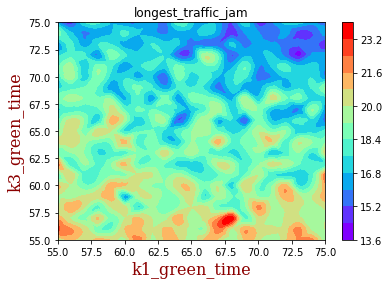

In [7]:
# auto-generated cell

import csv
import itertools

params_dictionary = {}
output_path = "results/scan.csv"
outputs = ['longest_traffic_jam']
X1 = list(range(55, 75 + 1, 1))
X2 = list(range(55, 75 + 1, 1))
iteration = 0
with open(output_path, 'w', encoding='UTF8') as f:
    writer = csv.writer(f, delimiter=",")
    csv_list = list(params_dictionary.keys()) + outputs
    writer.writerow(csv_list)
    design = itertools.product(X1, X2)
    for point in design:
        params_dictionary.update({'k1_green_time': point[0]})
        params_dictionary.update({'k3_green_time': point[1]})
        iteration += 1
        print(f'{iteration}, {params_dictionary}')
        csv_list = list(params_dictionary.values()) + run_simulation(params_dictionary, outputs)
        writer.writerow(csv_list)
f.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


def draw_heatmap(output_path, x_label, y_label, title):  # Load data from CSV
    dat = np.genfromtxt(output_path, delimiter=',', skip_header=1)
    X_dat = dat[:, 0]
    Y_dat = dat[:, 1]
    Z_dat = dat[:, 2]
    font = {'family': 'serif',
            'color': 'darkred',
            'weight': 'normal',
            'size': 13,
            }
    # Convert from pandas dataframes to numpy arrays
    X, Y, Z, = np.array([]), np.array([]), np.array([])
    for i in range(len(X_dat)):
        X = np.append(X, X_dat[i])
        Y = np.append(Y, Y_dat[i])
        Z = np.append(Z, Z_dat[i])

    # create x-y points to be used in heatmap
    xi = np.linspace(X.min(), X.max(), 1000)
    yi = np.linspace(Y.min(), Y.max(), 1000)

    # Interpolate for plotting
    zi = griddata((X, Y), Z, (xi[None, :], yi[:, None]), method='cubic')  # cubic, linear, nearest

    # Create the contour plot
    CS = plt.contourf(xi, yi, zi, 10, cmap=plt.cm.rainbow,
                      vmax=Z.max(), vmin=Z.min())
    plt.xticks(np.arange(X.min(), X.max() + 1, 5))
    plt.yticks(np.arange(Y.min(), Y.max() + 1, 5))
    plt.xlabel(x_label + " [seconds]", fontdict=font)
    plt.ylabel(y_label + " [seconds]", fontdict=font)
    plt.title(title + " [number of cars]")
    plt.colorbar()
    plt.show()
        
draw_heatmap(output_path, 'k1_green_time', 'k3_green_time', outputs[0])

### Result
The parameter k3_green_time has a higher impact on the the size of the emerging traffic jams.

## Simulation Experiment: Optimization

To investigate this further and to find the optimal traffic light configuration, an optimization experiment shall be conducted. For this, we want to narrow the parameter ranges as follows:

In [8]:
k1_green_time=[65,75,70] # @parameter

k3_green_time=[70,75,72] # @parameter

20 # @population
3 # @generations

3

In [9]:
# auto-generated cell

from scipy.optimize import differential_evolution

def transform_list_to_dict(parameters):
    dict = {}
    dict.update({"k1_green_time": parameters[0]})
    dict.update({"k3_green_time": parameters[1]})
    print(dict)
    return_values = run_simulation(dict, ['longest_traffic_jam'])
    print("Simulation output: " + str(return_values[0]))
    return return_values[0]

result = differential_evolution(transform_list_to_dict, ((65, 75), (70, 75)), x0=[70, 72], maxiter=3, popsize=20)
print("The optimal parametrization is: " + str(result.x))
print("The optimal value of the objective function is: " + str(result.fun))

{'k1_green_time': 70.0, 'k3_green_time': 72.0}
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was

The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 8 cars long
The longest traffic jam was on the lane from Südring t

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
Simulation output: 15.15
{'k1_green_time': 65.60437807524903, 'k3_green_time': 74.12804942069471}
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Süd

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
Simulation output: 18.2
{'k1_green_time': 73.70885951899686, 'k3_green_time': 74.56071144358562}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 33 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 37 cars long
The longest traffic jam was on the lane from Südring to

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
Simulation output: 16.15
{'k1_green_time': 68.72743227812121, 'k3_green_time': 71.36201425512135}
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 34 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower

The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße 

The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkoloni

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 7 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower St

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
Simulation output: 16.95
{'k1_green_time': 67.23242630220659, 'k3_green_time': 72.72112039386403}
The longest traffic jam was on the lane from Südring to Satower Straße and

The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
Simulation output: 18.0
{'k1_green_time': 71.08216305348279, 'k3_green_time': 72.50007428811652}
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einst

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
Simulation output: 13.9
{'k1_green_time': 70.65320469003716, 'k3_green_time': 71.22189436509696}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 6 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südri

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straß

The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße 

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 7 cars long
The longest traffic jam was on the lane from Südrin

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
Simulation output: 15.0
{'k1_green_time': 68.29487284248098, 'k3_

The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
Simulation output: 15.6
{'k1_green_time': 67.21430132904032, 'k3_green_time': 70.43479713340884}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane 

The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
Simulation output: 14.9
{'k1_green_time': 71.35823319928133, 'k3_green_time': 71.30452110910834}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring t

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Str

The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 5 cars long
The longest traffic jam was on the lane from Albert-Einstein-Straße to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the la

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the 

The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 22 cars long
Simulation output: 14.5
{'k1_green_time': 69.6498501513

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
Simulation output: 17.65
{'k1_green_time': 66.38914921750619, 'k3_green_time': 72.41119753778133}
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lan

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
Simulation output: 16.4
{'k1_green_time': 71.40102815180785, 'k3_green_time': 70.52180196163354}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to S

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and 

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on 

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 33 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Sat

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 8 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
Simulation output: 17.35
{'k1_green_time': 74.57577310394848, 'k3_green_tim

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
Simulation output: 14.85
{'k1_green_time': 73.23257073209197, 'k3_green_time': 74.33143461303139}
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 29 cars long
The longest traffic jam was on the lane from Sü

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
Simulation output: 14.95
{'k1_green_time': 68.21948518346525, 'k3_green_time': 70.28538142495869}
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane

The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
Simulation output: 15.95
{'k1_green_time': 73.22811556697377, 'k3_green_time': 74.09726633534099}
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 7 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring t

The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 25 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Sato

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 25 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 28 cars long
The longest traffic jam was on the lane from Satower Straße

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane 

The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 9 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
Simulation output: 14.7
{'k1_green_time': 74.7539084434813, 'k3_green_time': 72.11690690102233}
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-E

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
Simulation output: 15.35
{'k1_green_time': 66.11849893283916, 'k3_green_time': 72.40583633629471}
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on t

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 13 cars long
Simulation output: 15.45
{'k1_green_time': 74.43749461246294, 'k3_green_time': 70.77150062693681}
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lan

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and

The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 7 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on 

The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
Simulation output: 16.75
{'k1_green_time': 74.43525157259424, 'k3_green_time': 70.7713172510724}
The longest traffic jam was on the lane from Südring to Sato

The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
Simulation output: 13.35
{'k1_green_time': 74.43622377384807, 'k3_green_time': 70.7713967378417}
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Sato

The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 28 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
Simulation output: 15.75
{'k1_green_time': 74.43708446610763, 'k3_green_time': 70.77146708810537}
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satowe

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 11 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 30 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 8 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 7 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße 

The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 8 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 30 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on

The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 26 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 9 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 29 cars long
The longest traffic jam was on the lane from Südring t

The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 23 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
Simulation output: 16.45
{'k1_green_time': 74.43749241412428, 'k3_green_ti

The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 12 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 15 cars long
Simulation output: 15.2
{'k1_green_time': 74.43749387059724, 'k3_green_time': 70.77150055629045}
The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Satower S

The longest traffic jam was on the lane from Südring to Satower Straße and was 14 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
Simulation output: 15.35
{'k1_green_time': 74.43749422432622, 'k3_green_time': 70.77150058438976}
The longest traffic jam was on the lane from Südring to Satower Straße and was 18 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 10 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 18 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 13 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 9 cars long
The longest traffic jam was on the lane from Südring to S

The longest traffic jam was on the lane from Südring to Satower Straße and was 19 cars long
The longest traffic jam was on the lane from Satower Straße to Gartenkolonie and was 19 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 22 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 27 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-Straße and was 11 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Satower Straße

The longest traffic jam was on the lane from Südring to Satower Straße and was 21 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 17 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 24 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 20 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 16 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 13 cars long
The longest traffic jam was on the lane from Südring to Satower Straße and was 15 cars long
The longest traffic jam was on the lane from Satower Straße to Albert-Einstein-S